<a href="https://colab.research.google.com/github/sayan0506/Autoencoder-and-PCA-comparative-study/blob/master/Fashion_MNIST_Noisy_CNN_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising with a CNN Autoencoder

In the final lab for this week, you will introduce noise to the Fashion MNIST dataset and train an autoencoder to reconstruct the original input images.

## Imports

In [17]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

# Clear Session

In [26]:
tf.keras.backend.clear_session()

## Prepare the Dataset

You will prepare the train and test sets a little differently this time. Instead of just normalizing the images, you will also introduce random noise and the generated images will be used as input to your model. The target or label will still be the clean images.

In [2]:
def map_image_with_noise(image, label):
  '''Normalizes the images and generates noisy inputs.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  
  noise_factor = 0.5
  factor = noise_factor * tf.random.normal(shape=image.shape)
  image_noisy = image + factor
  image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)
 
  return image_noisy, image

In [19]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
# test_dataset.map() helps to map the test_images to map with the function attribute passed
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

## Build the Model

You will use the same model from the previous lab.

<img src="https://drive.google.com/uc?export=view&id=15zh7bst9KKvciRdCvMAH7kXt3nNkABzO" width="75%" height="75%"/>

In [20]:
def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

In [21]:
def bottle_neck(inputs):
  '''Defines the bottleneck.'''
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

In [22]:
def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  # upsampling2D is the reverse pf maxpool
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

In [23]:
def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)
  
  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return model, encoder_model

In [24]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 128)         2950

## Compile and Train the Model

In [25]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

Epoch 1/40
937/937 [==============================] - 21s 21ms/step - loss: 0.3371 - val_loss: 0.2948
Epoch 2/40
937/937 [==============================] - 18s 19ms/step - loss: 0.2911 - val_loss: 0.2895
Epoch 3/40
937/937 [==============================] - 18s 19ms/step - loss: 0.2865 - val_loss: 0.2873
Epoch 4/40
937/937 [==============================] - 18s 19ms/step - loss: 0.2846 - val_loss: 0.2860
Epoch 5/40
937/937 [==============================] - 18s 19ms/step - loss: 0.2834 - val_loss: 0.2856
Epoch 6/40
937/937 [==============================] - 18s 19ms/step - loss: 0.2821 - val_loss: 0.2840
Epoch 7/40
937/937 [==============================] - 18s 19ms/step - loss: 0.2815 - val_loss: 0.2838
Epoch 8/40
937/937 [==============================] - 18s 19ms/step - loss: 0.2810 - val_loss: 0.2833
Epoch 9/40
937/937 [==============================] - 18s 19ms/step - loss: 0.2804 - val_loss: 0.2827
Epoch 10/40
937/937 [==============================] - 18s 19ms/step - loss: 0.280

# Training History

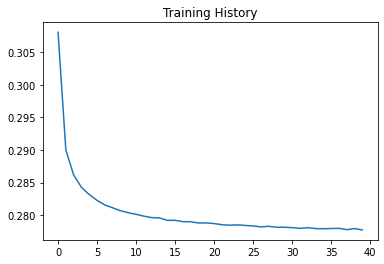

In [30]:
epochs = range(40)
loss = conv_model_history.history['loss']
plt.plot(epochs, loss)
plt.title('Training History')
plt.show()

## Display sample results

Let's see if the model can generate the clean image from noisy inputs.

In [27]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, noisy_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    noisy_image = np.reshape(noisy_image, shape)
    plt.imshow(noisy_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

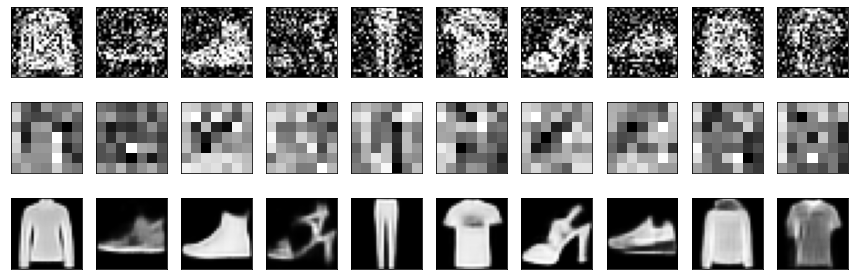

In [28]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))